# Bike Sharing Demand

In [1]:
import sys

import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Разглеждан data set: [bike-sharing](https://www.kaggle.com/c/bike-sharing-demand)

In [2]:
train = pd.read_csv("data\\train.csv", index_col = False)
test = pd.read_csv("data\\test.csv", index_col = False)

Нека видим с какво се захващаме.

In [3]:
train.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


In [4]:
test.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
5,2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013
6,2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013
7,2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013
8,2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012
9,2011-01-20 09:00:00,1,0,1,2,9.84,11.365,52,15.0013


In [5]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [6]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

In [7]:
set(train.columns) - set(test.columns)

{'casual', 'count', 'registered'}

Условието на състезанието и малко повече инофрмация за data set-a можем да видим [тук](https://www.kaggle.com/c/bike-sharing-demand/data)

Виждаме, че train set-a съдържа информация за броя наети колелета на всеки час през първите 19 дни от всеки месец в рамките на две години.
Нашата задача е да предскажем броя наети колелета на всеки час за останалите дни от всеки месец в рамките на същите две години.

Feature-ите са следните :

* datetime - година-месец-ден час:минута:секунда
* season -  1 = пролет, 2 = лято, 3 = есен, 4 = зима 
* holiday - дали денят е празник
* workingday - дали денят е работен
* weather -  1 = Ясно, Малка облачност, Частична облачност, 2 = Мъгла + Облаци, 3 = Лек сняг, лека облачност, слаб дъжд + гръмотевична буря + разкъсана облачност, слаб дъжд + разпръснати облаци, 4 = Силен дъжд + градушка + гръмотевична буря + мъгла, сняг + мъгла
* temp - температура
* atemp - "усеща се като"
* humidity - влажност
* windspeed - скорост на вятъра
* casual - брой наети колелета от нерегистрирани user-и
* registered - брой наети колелета от регистрирани user-и
* count - общ брой наети колелета

Да видим дали имаме нечислови и null стойности.

In [8]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [9]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

С радост откриваме, че нямаме null стойности и само стойностите на feature-а datetime са нечислови.
Нека поправим това.

In [10]:
import datetime
# създаваме работно копие на train set-а
transformed_train = train.copy()
transformed_train['datetime'] = transformed_train['datetime'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
transformed_train['year'] = transformed_train['datetime'].apply(lambda x:x.year)
transformed_train['month'] = transformed_train['datetime'].apply(lambda x:x.month)
transformed_train['day'] = transformed_train['datetime'].apply(lambda x:x.day)
transformed_train['hour'] = transformed_train['datetime'].apply(lambda x:x.hour)
transformed_train = transformed_train.drop(['datetime'], axis=1)

In [11]:
transformed_train.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
year            int64
month           int64
day             int64
hour            int64
dtype: object

Вече имаме само числови стойности. Време е за **baseline** модел.

In [12]:
from sklearn.model_selection import train_test_split
train_no_count = transformed_train.drop(labels=['count','registered','casual'], axis=1)
train_count = transformed_train['count']
X_train, X_test, y_train, y_test = train_test_split(train_no_count, 
                                                    train_count, 
                                                    test_size=0.3, 
                                                    random_state=4200)

In [13]:
from sklearn.linear_model import LinearRegression

lrgr = LinearRegression()
lrgr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
print("train score: ", lrgr.score(X_train, y_train))
print("test score: ", lrgr.score(X_test, y_test))

train score:  0.397157331347
test score:  0.369078905174


Трагичен резултат, но това не ни плаши особено. Нека пробваме с Random Forest.

In [15]:
from sklearn.ensemble import RandomForestRegressor
rfrgr = RandomForestRegressor(n_estimators=100, n_jobs=2)
rfrgr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [16]:
print("train score: ", rfrgr.score(X_train, y_train))
print("test score: ", rfrgr.score(X_test, y_test))

train score:  0.991830003697
test score:  0.941787934644


# WOW

Очакваше се да има подобрение, защото Random Forest се справя с данни, които не са one hot encode-нати, каквито са и нашите, но увеличението на резултата е драстично. Нека пробваме да си поиграем с хипер-параметрите и да направим cross validation.

In [17]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(rfrgr, {'min_samples_split': [2, 5, 10, 12, 15],
                              'max_depth': [2, 4, 6, 8, 10, 12, 15]})
search.fit(X_train, y_train)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
30,1,0.931056,"{'max_depth': 15, 'min_samples_split': 2}"
31,2,0.930512,"{'max_depth': 15, 'min_samples_split': 5}"
32,3,0.927949,"{'max_depth': 15, 'min_samples_split': 10}"
25,4,0.927658,"{'max_depth': 12, 'min_samples_split': 2}"
26,5,0.927360,"{'max_depth': 12, 'min_samples_split': 5}"
33,6,0.924960,"{'max_depth': 15, 'min_samples_split': 12}"
27,7,0.923506,"{'max_depth': 12, 'min_samples_split': 10}"
28,8,0.923300,"{'max_depth': 12, 'min_samples_split': 12}"
34,9,0.922039,"{'max_depth': 15, 'min_samples_split': 15}"
29,10,0.921278,"{'max_depth': 12, 'min_samples_split': 15}"


Много висок начален резултат, но естествено няма да спра до тук. 

Вече е време да се запозная малко по-подробно с данните и да направя малко feature engineering.

Да погледнем какво разпределение имат даннните.

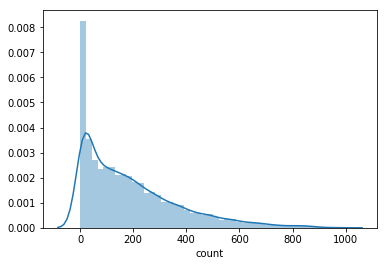

In [18]:
sns.distplot(transformed_train['count']);

Нека да прекараме това през логаритъм.

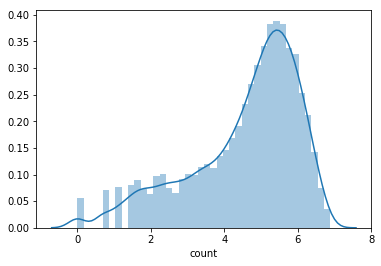

In [19]:
sns.distplot(np.log(transformed_train['count']))

In [20]:
transformed_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'year',
       'month', 'day', 'hour'],
      dtype='object')

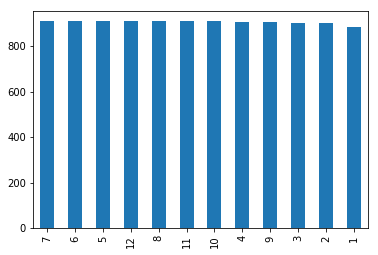

In [21]:
transformed_train['month'].value_counts().plot(kind='bar')

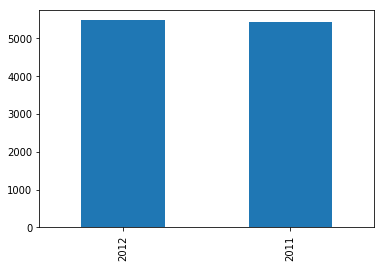

In [22]:
transformed_train['year'].value_counts().plot(kind='bar')

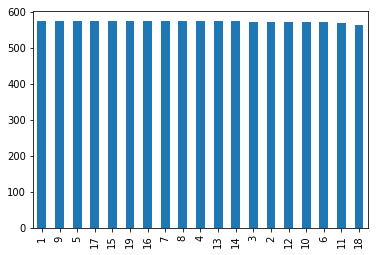

In [23]:
transformed_train['day'].value_counts().plot(kind='bar')

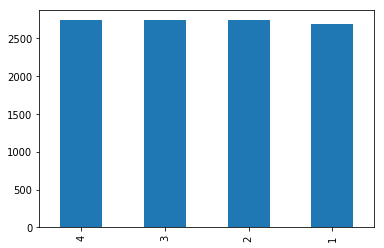

In [24]:
transformed_train['season'].value_counts().plot(kind='bar')

Времево данните са напълно равномерно разпределени. Това можеше да се очаква.

Нека видим какво ще ни покаже describe() метода

In [25]:
transformed_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,23.000000


Махаме колоните registered и casual, защото registered + casual = count, а колоната day я махаме, защото train данните са за първите 19 дни от всеки месец и не искаме да объркваме модела с това. Той трябва да може да предсказва за всички дни.

In [26]:
transformed_train = transformed_train.drop(labels=['registered','casual','day'], axis=1)

Нека сега направим heatmap (нещо, което видях от [тук](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python/notebook)), защото според мен това е най-бързият начин да видим дали има връзка м/у отделни feature-и.

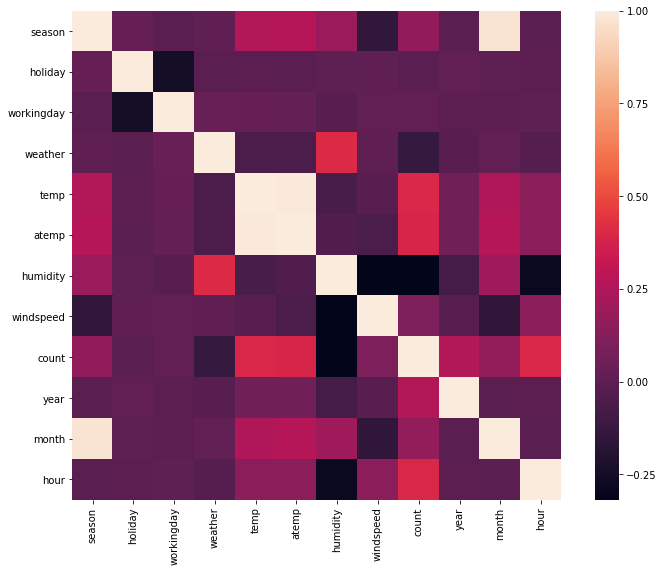

In [27]:
corrmat = transformed_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1., square=True);

Виждаме очаквано много силна връзка м/у месец и сезон, м/у temp(колко градуса е) и actual temp(като колко се усеща), м/у weather и humidity. По-интересното обаче е, че има добра корелация м/у count и temp/atemp и м/у count и hour. Нека видим тези корелации по-ясно.

[Text(0,0.5,'Avearage Count'),
 Text(0.5,0,'Month'),
 Text(0.5,1,'Average Count By Month')]

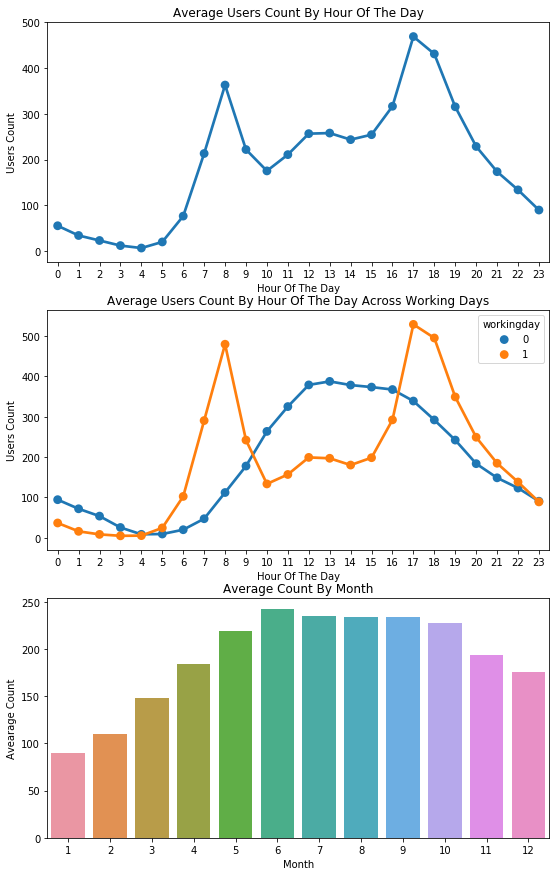

In [34]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(9,15)

hourAggregated = pd.DataFrame(transformed_train.groupby(["hour"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x='hour', y='count', data=hourAggregated, join=True,ax=ax1)
ax1.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day",label='big')

hourAggregated = pd.DataFrame(transformed_train.groupby(["hour","workingday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x='hour', y='count',hue='workingday', data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Working Days",label='big')

monthAggregated = pd.DataFrame(transformed_train.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sns.barplot(data=monthSorted,x='month',y='count',ax=ax3)
ax3.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

Виждаме неща, които не трябва да ни изненадват особено и са напълно очаквани. През по-топлите месеци има повече използвани колелета, през работните дни пиковете са около 08:00 и 18:00, когато най-вероятно хората ги ползват, за транспорт м/у работата и дома, а през почивните дни следобедните часове са по-предпочитани. 

Ще илюстрирам и някои други връзки.

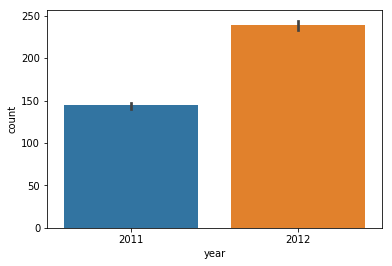

In [29]:
sns.barplot(x='year', y='count', data=transformed_train)

Може да направим очевидния извод, че през 2012 ползването на колелетата се е увеличило.

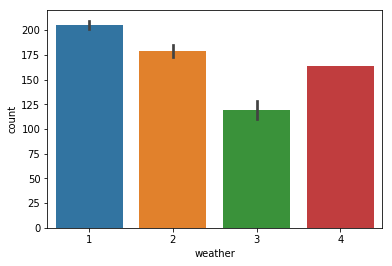

In [30]:
sns.barplot(x='weather', y='count', data=transformed_train)

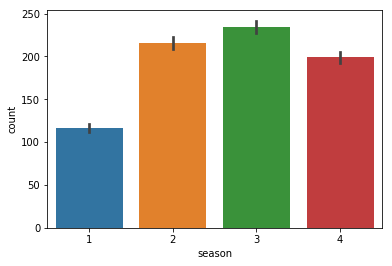

In [31]:
sns.barplot(x='season', y='count', data=transformed_train)

Отново неща, които не изненадват: лято и есен са най-предпочитаните сезони и по-доброто време е предпоставка за повече колоездачи.

In [28]:
for column in transformed_train.columns:
    print(transformed_train[column].value_counts())

4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64
0    10575
1      311
Name: holiday, dtype: int64
1    7412
0    3474
Name: workingday, dtype: int64
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64
14.76    467
26.24    453
28.70    427
13.94    413
18.86    406
22.14    403
25.42    403
16.40    400
22.96    395
27.06    394
24.60    390
12.30    385
21.32    362
13.12    356
17.22    356
29.52    353
10.66    332
18.04    328
20.50    327
30.34    299
9.84     294
15.58    255
9.02     248
31.16    242
8.20     229
27.88    224
23.78    203
32.80    202
11.48    181
19.68    170
6.56     146
33.62    130
5.74     107
7.38     106
31.98     98
34.44     80
35.26     76
4.92      60
36.90     46
4.10      44
37.72     34
36.08     23
3.28      11
38.54      7
0.82       7
39.36      6
2.46       5
1.64       2
41.00      1
Name: temp, dtype: int64
31.060    671
25.760    423
22.725    406
20.455    400
26.515    395
16.665    381
25.000    365
33.3

Ще махнем колонката temp, защото atemp е достатъчна. Виждаме обаче, че имаме над 1300 записа с нулево humidity. Можем да ги предскажем или да махнем колоната, или да ги попълним със средната стойност. Засега избираме третото.

In [42]:
transformed_train = transformed_train.drop(['temp'], axis=1)
non_zero_windspeed = transformed_train.windspeed.loc[(transformed_train.windspeed != 0)]
transformed_train['windspeed'] = transformed_train['windspeed'].replace(to_replace=0,value=non_zero_windspeed.mean())

In [30]:
transformed_train.windspeed.value_counts()

14.554917    1313
8.998100     1120
11.001400    1057
12.998000    1042
7.001500     1034
15.001300     961
6.003200      872
16.997900     824
19.001200     676
19.999500     492
22.002800     372
23.999400     274
26.002700     235
27.999300     187
30.002600     111
31.000900      89
32.997500      80
35.000800      58
39.000700      27
36.997400      22
43.000600      12
40.997300      11
43.998900       8
46.002200       3
56.996900       2
47.998800       2
50.002100       1
51.998700       1
Name: windspeed, dtype: int64

In [31]:
transformed_train.head(10)

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,year,month,hour
0,1,0,0,1,14.395,81,14.554917,16,2011,1,0
1,1,0,0,1,13.635,80,14.554917,40,2011,1,1
2,1,0,0,1,13.635,80,14.554917,32,2011,1,2
3,1,0,0,1,14.395,75,14.554917,13,2011,1,3
4,1,0,0,1,14.395,75,14.554917,1,2011,1,4
5,1,0,0,2,12.880,75,6.003200,1,2011,1,5
6,1,0,0,1,13.635,80,14.554917,2,2011,1,6
7,1,0,0,1,12.880,86,14.554917,3,2011,1,7
8,1,0,0,1,14.395,75,14.554917,8,2011,1,8
9,1,0,0,1,17.425,76,14.554917,14,2011,1,9


Нека one hot encode-нем и да видим какво ще се получи.

In [48]:
encoded_train = transformed_train.copy()

In [49]:
categorical_features = ['season', 'year', 'month', 'hour', 'holiday', 'workingday', 'weather']
for category in categorical_features:
    encoded_train[category] = encoded_train[category].astype("category")
encoded_train = pd.get_dummies(encoded_train)

In [50]:
encoded_train.head(10)

,atemp,humidity,windspeed,count,season_1,season_2,season_3,season_4,holiday_0,holiday_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,14.395,81,14.554917,16,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,13.635,80,14.554917,40,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,13.635,80,14.554917,32,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,14.395,75,14.554917,13,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,14.395,75,14.554917,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,12.880,75,6.003200,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,13.635,80,14.554917,2,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,12.880,86,14.554917,3,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,14.395,75,14.554917,8,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,17.425,76,14.554917,14,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
encoded_train.columns

Index(['atemp', 'humidity', 'windspeed', 'count', 'season_1', 'season_2',
       'season_3', 'season_4', 'holiday_0', 'holiday_1', 'workingday_0',
       'workingday_1', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'year_2011', 'year_2012', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'],
      dtype='object')

## Време е за модели!

In [62]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

encoded_train_no_count = encoded_train.drop('count', axis=1)
encoded_train_count = encoded_train['count']

train_no_count = transformed_train.drop('count', axis=1)
train_count = transformed_train['count']

rfrgr = RandomForestRegressor(n_jobs=2, n_estimators=100)
scores = cross_val_score(rfrgr, 
                         train_no_count, 
                         train_count, 
                         cv = KFold(n_splits = 4, shuffle = True, random_state=1000), 
                         n_jobs=2)
print(scores)
print("Mean: {}".format(scores.mean()))
print("Std:  {}".format(scores.std()))


lrgr = LinearRegression()
scores = cross_val_score(lrgr, 
                         encoded_train_no_count, 
                         encoded_train_count, 
                         cv = KFold(n_splits = 4, shuffle = True, random_state=1000), 
                         n_jobs=2, 
                         scoring='r2')
print(scores)
print("Mean: {}".format(scores.mean()))
print("Std:  {}".format(scores.std()))


[ 0.93705541  0.94404146  0.94352684  0.94401096]
Mean: 0.9421586693450518
Std:  0.002953429865807454
[  6.69134569e-01   6.97172042e-01   6.92422664e-01  -1.25129492e+14]
Mean: -31282372876284.387
Std:  54182659203040.305


Доста подобрихме линейната регресия(0.69 score, не знам защо излиза в такъв формат, а този последният резултат е много странен и не успях да си го обясня). Нека да пробваме с регуляризация.

In [63]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(encoded_train_no_count, encoded_train_count, test_size=0.3, random_state=1234)

alpha = [0.00001, 0.001, 0.01, 0.1, 1, 10, 100]

for a in alpha:
    ridge = Ridge(alpha = a).fit(X_train, y_train)
    print('alpha:', a)
    print(ridge.score(X_train, y_train), ridge.score(X_test, y_test))
    print()

alpha: 1e-05
0.700375559109 0.675116196154

alpha: 0.001
0.700375559042 0.675116318639

alpha: 0.01
0.700375552505 0.675117429094

alpha: 0.1
0.700374972063 0.675128249484

alpha: 1
0.700349779635 0.675217879749

alpha: 10
0.699739499643 0.675437110566

alpha: 100
0.671348467119 0.651872249985



In [64]:
from sklearn.linear_model import Lasso

alpha = [0.01, 0.1, 1, 10, 100]

for a in alpha:
    lasso = Lasso(alpha = a).fit(X_train, y_train)
    print('alpha:', a)
    print(lasso.score(X_train, y_train), lasso.score(X_test, y_test))
    print()

alpha: 0.01
0.700349024849 0.675154035545

alpha: 0.1
0.69994737011 0.67506360469

alpha: 1
0.676850832204 0.65501669857

alpha: 10
0.288917288869 0.280195636648

alpha: 100
0.239857409529 0.233919163332



Без особен успех .. 

Изглежда Random Forest е нашият модел. Нека да го GridSearch крос валидираме. Ще ползваме данните, които не са encode-нати, защото така е по-добре за RF(според хората в интернет).

In [66]:
search = GridSearchCV(rfrgr, {'min_samples_leaf': [1, 2, 8, 12, 15, 25],
                              'max_depth': [6, 8, 10, 12, 15, 20, 25]
                             }, cv=KFold(n_splits = 4, shuffle = True, random_state=1000))
search.fit(train_no_count, train_count)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
30,1,0.941996,"{'max_depth': 20, 'min_samples_leaf': 1}"
36,2,0.941741,"{'max_depth': 25, 'min_samples_leaf': 1}"
31,3,0.941651,"{'max_depth': 20, 'min_samples_leaf': 2}"
24,4,0.941643,"{'max_depth': 15, 'min_samples_leaf': 1}"
25,5,0.941353,"{'max_depth': 15, 'min_samples_leaf': 2}"
37,6,0.941157,"{'max_depth': 25, 'min_samples_leaf': 2}"
18,7,0.939039,"{'max_depth': 12, 'min_samples_leaf': 1}"
19,8,0.938269,"{'max_depth': 12, 'min_samples_leaf': 2}"
38,9,0.930321,"{'max_depth': 25, 'min_samples_leaf': 8}"
32,10,0.929968,"{'max_depth': 20, 'min_samples_leaf': 8}"


Остава само да натренираме модела върху цялото train множество и да submit-нем решение в kaggle.

Трансформираме тест сет-а по същия начин.

In [67]:
test = pd.read_csv("data\\test.csv", index_col = False)
datetimecol = test.datetime
test['datetime'] = test['datetime'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
test['year'] = test['datetime'].apply(lambda x:x.year)
test['month'] = test['datetime'].apply(lambda x:x.month)
test['day'] = test['datetime'].apply(lambda x:x.day)
test['hour'] = test['datetime'].apply(lambda x:x.hour)
test = test.drop(['datetime', 'day'], axis=1)
test = test.drop(['temp'], axis=1)
non_zero_windspeed = test.windspeed.loc[(test.windspeed != 0)]
test['windspeed'] = test['windspeed'].replace(to_replace=0,value=non_zero_windspeed.mean())
categorical_features = ['season', 'year', 'month', 'hour', 'holiday', 'workingday', 'weather']
# for category in categorical_features:
#     test[category] = test[category].astype("category")
# test = pd.get_dummies(test)

In [68]:
test.head(10)

,season,holiday,workingday,weather,atemp,humidity,windspeed,year,month,hour
0,1,0,1,1,11.365,56,26.002700,2011,1,0
1,1,0,1,1,13.635,56,14.577694,2011,1,1
2,1,0,1,1,13.635,56,14.577694,2011,1,2
3,1,0,1,1,12.880,56,11.001400,2011,1,3
4,1,0,1,1,12.880,56,11.001400,2011,1,4
5,1,0,1,1,11.365,60,15.001300,2011,1,5
6,1,0,1,1,10.605,60,15.001300,2011,1,6
7,1,0,1,1,10.605,55,15.001300,2011,1,7
8,1,0,1,1,10.605,55,19.001200,2011,1,8
9,1,0,1,2,11.365,52,15.001300,2011,1,9


In [69]:
rfrgr = RandomForestRegressor(n_jobs=2, n_estimators=100, max_depth=20, min_samples_leaf=1)
rfrgr.fit(train_no_count, train_count)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [70]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": rfrgr.predict(test)
    })
submission.to_csv('data\\bike-sharing-submission.csv', index=False)

### Класиране: 1200 от 3200

# Заключение

Data set-a не беше особено предизвикателен(все пак го избрах след като google-нах нещо от сорта на: "data sets for begginers"), но беше добър като за начало. Може би логично RF се справи драстично по-добре, защото научи зависимости, които всеки можеше да очаква(пример: сутрин в 8 и вечер в 6 в работните дни има най-много потребление на колелета; в студените месеци се ползват по-малко колелета и т.н.). Нямаше място за много feature engineering, но си струваше да визуализирам данните, защото това беше полезно упражнение. 